# Monte Carlo Methods

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en OpenAi gym (https://gym.openai.com/), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El ambiente esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 

***
### Juego de Blackjack

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable".
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador de queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

Ambiente:
- La reward por perder es -1, por ganar es +1 y por pedir carta es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

***

### A entregar:

- Notebook con solución a los algoritmos presentados
- Analisis de la funcion de valor estimada para distinto número de episodios a visitar (ej: 100, 1000, 10000, 50000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de funcion de valor para otras dos politicas definidas por el estudiante. 

In [1]:
# Para utilizar la nueva version de GYM, si es necesario reiniciar ambiente
!pip install --upgrade gym

In [8]:
# Imports necesarios
import gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Creacion del ambiente
#env = gym.make('Blackjack-v0')
env = gym.make('Blackjack-v1',natural=False, sab=True)

# Acciones: 0 = Stick, 1 = HIT
print(env.observation_space)

#obs = env.reset()
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")


#nueva_obs, reward, done, _ = env.step(0)
nueva_obs, reward, done, truncated, _ = env.step(0)

print(f"Nuevo estado: {nueva_obs}, Recompensa: {reward}, Estado Final: {done}")

Tuple(Discrete(32), Discrete(11), Discrete(2))
Jugador: 19, Dealer: 1, As usable: False 
Nuevo estado: (19, 1, False), Recompensa: 1.0, Estado Final: True


In [20]:
# Caso de prueba
#state,_ = env.reset()
state,_ = env.reset()
print('state:', state)

while True:
    action = env.action_space.sample()
    #state, reward, done, _ = env.step(action)
    state, reward, done, truncated, _ = env.step(action)
    print('state:', state, 'reward:', reward, 'done:', done, 'truncated:', truncated)
    if done or truncated:
        print(f'Reward:{reward}')                
        break

state: (20, 5, False)
state: (27, 5, False) reward: -1.0 done: True truncated: False
Reward:-1.0


## El algoritmo que vamos a implementar

Vamos a comenzar con el algoritmo 5.1 del libro: `First Visit MC prediction` para estimar la función de valor de una política arbitraria. 

![Image](https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/assets/0501_FV_MC_Pred.png)

En este caso vamos a querer evaluar una politica que se queda si el jugador tiene un valor mayor o igual a 19, y pide cartas en caso contrario. 



In [23]:
STICK = 0
HIT = 1
       
## Politica
def sample_policy(observation):
    sumajugador, cartaDealer, usableAce = observation
    return STICK if sumajugador >= 19 else HIT

In [26]:
## Generar Episodio
def generate_episode(policy, env):
    states, actions, rewards = [], [], []    

    state, _ = env.reset()
    while True:
        action = policy(state)
        actions.append(action)
        states.append(state)
        state, reward, done, truncated, _ = env.step(action)
        rewards.append(reward)
        if done or truncated:
            break

    return states, actions, rewards

In [27]:
generate_episode(sample_policy, env)

([(17, 8, False), (21, 8, False)], [1, 0], [0.0, 1.0])

In [28]:
## Algoritmo
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1):
    # defaultdict(float) es una clase del módulo collections de Python que se utiliza para crear un diccionario que devuelve un valor predeterminado de tipo float cuando se accede a una clave inexistente.
    V = defaultdict(float)
    # returns es un diccionario de listas donde la clave es el estado
    returns = defaultdict(list)

    # tqdm es una barra de progreso
    for i in tqdm(range(number_episodes)):
        states, _, rewards = generate_episode(policy, env)
        G = 0
        for t in range(len(states)-1, -1, -1):
            G = gamma * G + rewards[t]
            # Si el estado no esta en los estados anteriores (es decir, es el primer visit)
            if states[t] not in states[:t]:
                returns[states[t]].append(G)
                V[states[t]] = np.mean(returns[states[t]])

    return V

In [32]:
# Uso copy popitem modifica la estructura
from copy import copy

value = first_visit_mc_prediction(sample_policy, env, number_episodes=500000)

valueaux = copy(value)
for i in range(10):
    print(valueaux.popitem())

100%|██████████| 500000/500000 [03:35<00:00, 2315.96it/s]

((4, 4, False), -0.25523012552301255)
((12, 9, True), -0.039647577092511016)
((12, 5, True), -0.02066115702479339)
((4, 3, False), -0.2579185520361991)
((12, 1, True), -0.3510204081632653)
((14, 8, True), -0.10303030303030303)
((13, 6, True), -0.044585987261146494)
((8, 7, False), -0.3264822134387352)
((16, 9, True), -0.21543408360128619)
((18, 6, True), -0.2982216142270862)


In [30]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_value_distribution(value):
    min_x = min(k[0] for k in value.keys())
    max_x = max(k[0] for k in value.keys())
    min_y = min(k[1] for k in value.keys())
    max_y = max(k[1] for k in value.keys())

    player_sum = np.arange(min_x, max_x + 1)
    dealer_show = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(player_sum, dealer_show)

    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = value[player, dealer, ace]
    
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    plt.title("Distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.view_init(ax.elev, -120)
    ax.plot_surface(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

    #Gráfico de contorno
    cp = plt.contourf(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm)
    plt.title("Contorno distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")        
    plt.colorbar(cp)
    plt.show()

    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    plt.title("Distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.view_init(ax.elev, -120)
    ax.plot_surface(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()
    
    #Gráfico de contorno
    cp = plt.contourf(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm)
    plt.title("Contorno distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")        
    plt.colorbar(cp)
    plt.show()
    

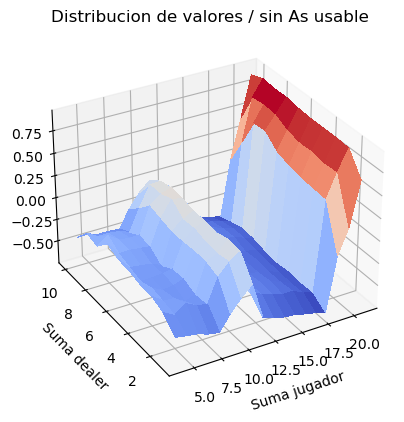

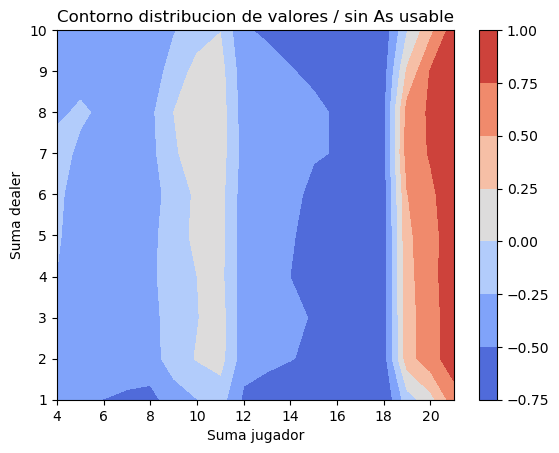

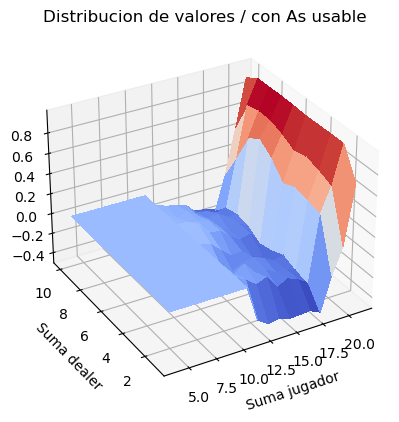

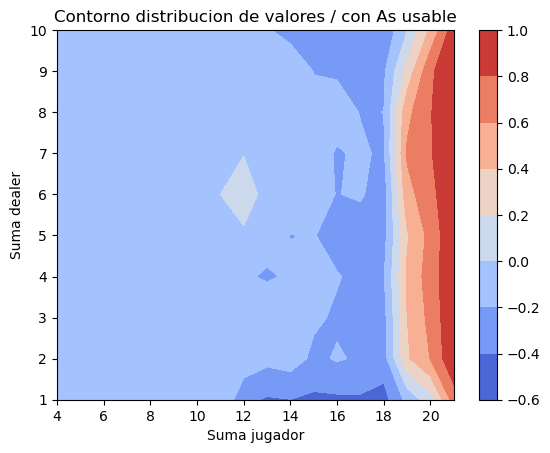

In [33]:
plot_value_distribution(value)

## Opcional
En esta sección presentamos las definiciones de funciones del resto de las técnicas vistas en teórico para aquellos que quieran implementarlas.

In [36]:
def first_visit_mc_prediction_Q(policy, env, number_episodes, gamma=1):
    # Q es un diccionario de diccionarios donde la clave es el estado y la acción.
    # El valor es un array de numpy con los valores de Q para cada acción.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)

    for i in tqdm(range(number_episodes)):
        states, actions, rewards = generate_episode(policy, env)
        G = 0
        for t in range(len(states)-1, -1, -1):
            G = gamma * G + rewards[t]
            if (states[t], actions[t]) not in [(states[s], actions[s]) for s in range(t)]:
                returns[(states[t], actions[t])].append(G)
                Q[states[t]][actions[t]] = np.mean(returns[(states[t], actions[t])])
    return Q

¿Observa algo extraño en los valores Q?

In [39]:
Qvalues = first_visit_mc_prediction_Q(sample_policy, env, number_episodes=500000)
Qvaluesaux = copy(Qvalues)
for i in range(100):
    print(Qvaluesaux.popitem())


100%|██████████| 500000/500000 [03:02<00:00, 2735.11it/s]

((4, 7, False), array([ 0.        , -0.24468085]))
((12, 3, True), array([ 0.        , -0.04522613]))
((12, 9, True), array([ 0.        , -0.01785714]))
((15, 8, True), array([ 0.        , -0.13028169]))
((12, 8, True), array([0.        , 0.12663755]))
((6, 7, False), array([ 0.        , -0.31240876]))
((13, 1, True), array([ 0.        , -0.31041257]))
((17, 7, True), array([ 0.        , -0.18119891]))
((4, 5, False), array([ 0.        , -0.36486486]))
((12, 2, True), array([ 0.        , -0.09130435]))
((16, 5, True), array([ 0.        , -0.12418301]))
((15, 6, True), array([ 0.        , -0.19516408]))
((12, 1, True), array([ 0.        , -0.37804878]))
((5, 2, False), array([ 0.        , -0.33673469]))
((4, 8, False), array([ 0.        , -0.20577617]))
((5, 3, False), array([ 0.        , -0.38924731]))
((12, 5, True), array([ 0.        , -0.08438819]))
((4, 3, False), array([ 0.        , -0.23557692]))
((13, 7, True), array([ 0.        , -0.06666667]))
((14, 1, True), array([ 0.       

In [43]:
def generate_value_function(Q):
    V = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        V[state] = action_value
    return V

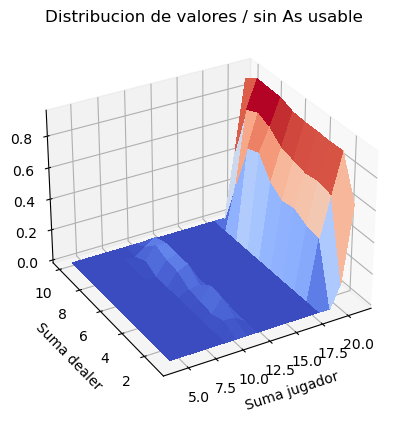

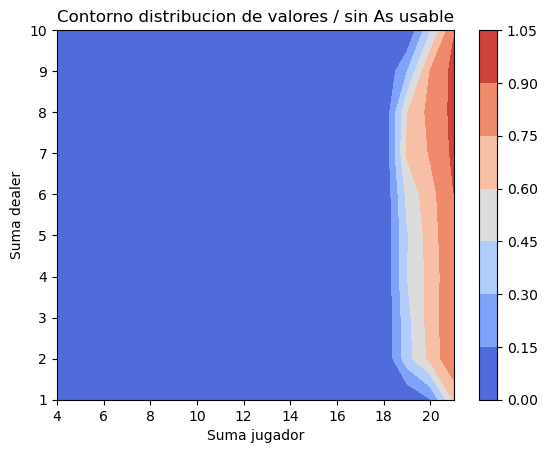

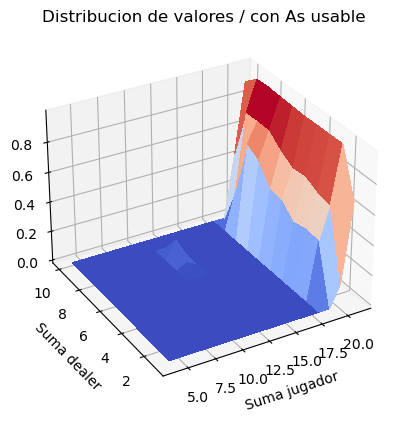

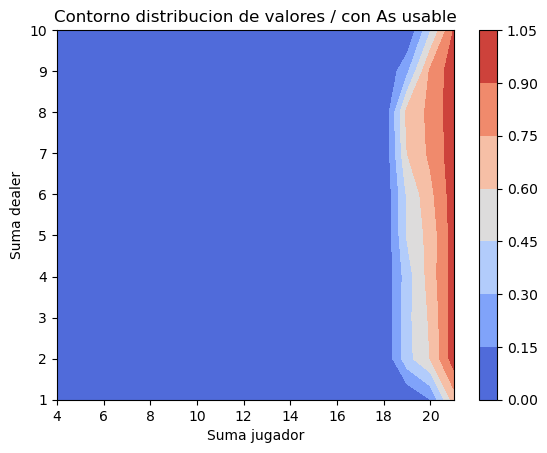

In [44]:
value = generate_value_function(Qvalues)
plot_value_distribution(value)

In [14]:
def first_visit_mc_prediction_Q_with_initial_exploration(policy, env, number_episodes, gamma=1):
    #TODO: Implement
    """
    Los siguientes snippets pueden serle de utilidad:
        random_action = env.action_space.sample()
        random_state = env.observation_space.sample()
    """
    pass


Antes de implementar Control MC, definiremos la clase Policy.

Esta se puede instanciar tanto para implementar:
- Una política puramente greedy (ε = 0) para Control MC **con** exploración inicial
- Una política ε-greedy para Control MC **sin** exploración inicial

In [15]:
class Policy:
    """
    Implements an epsilon-soft policy, one that returs a probability distribution for each possible action.
    
    Params
    ------
        Q: dictionary of state-action keys -> array of returns.
        number_actions: number of possible actions in the env.
        epsilon: exploration parameter where 1 explores all the time and 0 is greedy. 
    """
    
    def __init__(self, Q, number_actions, epsilon=0.1):
        self.Q = Q
        self.number_actions = number_actions
        self.epsilon = epsilon
    
    def __call__(self, observation):
        #TODO: implement
        # Se debe retornar el vector de probabilidades (página 14 del teórico).
        # Recordar, si ε = 0 -> la política es la greedy (página 13 del teórico).
        pass
    
    def update(self, new_Q):
        self.Q = new_Q

In [ ]:
def monte_carlo_control_without_initial_exploration(env, num_episodes, gamma=1, epsilon=0.1):
    #TODO: Implement
    pass